# Complete error estimation  

In [1]:
import numpy as np
import matplotlib.pyplot
import pymc3 as pm
import pandas as pd
import scipy.special
import scipy.stats
import matplotlib.pyplot as plt
import theano.tensor as tt
import sys
sys.path.insert(0, '../../')
import mwc.viz
import mwc.bayes
import mwc.stats
colors = mwc.viz.personal_style()
np.random.seed(666)
%matplotlib inline

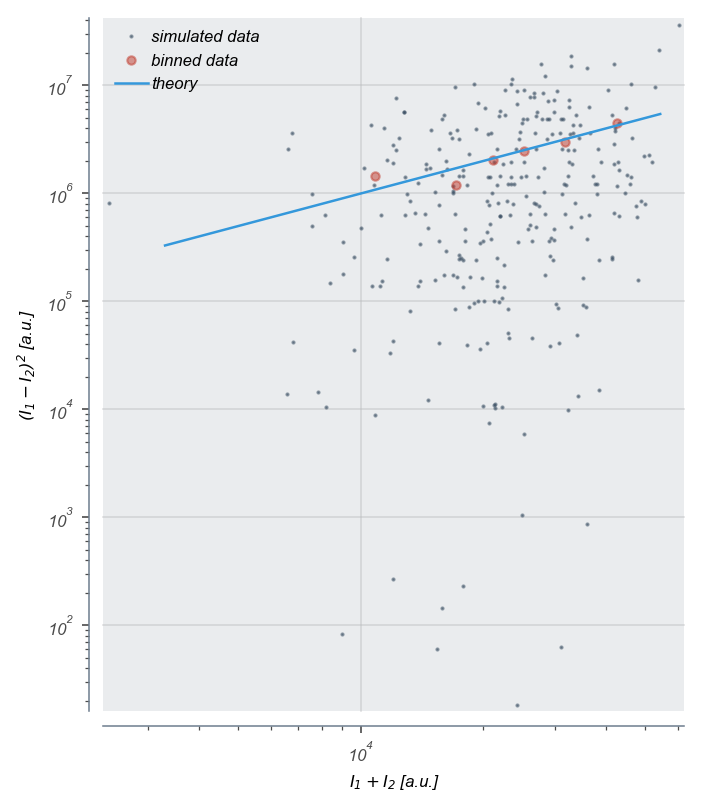

In [2]:
# Simulate the data.
num_div = 300
ntot = np.random.gamma(5, 50, size=num_div).astype(int)
n1 = np.random.binomial(ntot, p=0.5)
n2 = ntot - n1

# Define alpha with measurement noise. 
alpha_true = 100
err = 10

# Compute the intensities.
i1 = alpha_true * n1 + np.random.normal(0, err, size=num_div)
i2 = alpha_true * n2 + np.random.normal(0, err, size=num_div)
itot = i1 + i2

# Make a dataframe. 
df = pd.DataFrame(np.array([i1, i2, i1 + i2, (i1 - i2)**2]).T, 
                 columns=['I_1', 'I_2', 'summed', 'fluct'])

df = df[(df['I_1'] >= 0) & (df['I_2'] >= 0)]
# Bin the data
bin_size = 50 
bin_dict = mwc.stats.bin_by_events(df, 50)

# Compute the theory. 
i_tot_range = np.linspace(itot.min(), itot.max(), 500)
theo = alpha_true * i_tot_range
# Plot the data. 
fig, ax = plt.subplots(1,1, figsize=(5, 6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_1 + I_2$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')
_ = ax.plot(i1 + i1, (i1 - i2)**2, '.', ms=2, alpha=0.5, label='simulated data')
_ = ax.plot(bin_dict['summed'], bin_dict['fluct'], '.', ms=8, alpha=0.5, label='binned data')
_ = ax.plot(i_tot_range, theo, label='theory')
_ = ax.legend()
mwc.viz.format_axes()

In [ ]:
def log_post()

In [40]:
class ErrorModel(pm.Continuous):
    def __init__(self, alpha, N1, Ntot, I1, I2, *args, **kwargs):
        super(ErrorModel, self).__init__(*args, **kwargs)
        self.alpha = alpha = pm.theanof.floatX(tt.as_tensor_variable(alpha))
        self.n1 = N1 = pm.theanof.floatX(tt.as_tensor_variable(N1))
        self.ntot = Ntot = pm.theanof.floatX(tt.as_tensor_variable(Ntot))
        self.n2 = Ntot - N1
        self.i1 = I1
        self.i2 = I2

    
    def logp(self, value):
        alpha = self.alpha
        n1 = self.n1
        ntot = self.ntot 
        i1 = self.i1
        i2 = self.i2
        k = len(i2)
        
        # Compute the various parts
        return -0.5 * k * tt.log(tt.sum((i1 - alpha * n1)**2  - (i2 - alpha * (ntot - n1)**2)))
         
        
class GammaApproxBinomial(pm.Continuous):
    def __init__(self, ntot, p, *args, **kwargs):
        super(GammaApproxBinomial, self).__init__(*args, **kwargs)
        self.ntot = ntot = pm.theanof.floatX(tt.as_tensor_variable(ntot))
        self.p = p = pm.theanof.floatX(tt.as_tensor_variable(p)) 
        self.mean = self.ntot * self.p
    
    def logp(self, value):
        ntot= self.ntot
        p = self.p
        n1 = value
        coeff = tt.gammaln(ntot + 1) - tt.gammaln(n1 + 1) - tt.gammaln(ntot - n1 + 1)
        prob = n1 * tt.log(p) + (ntot - n1) * tt.log(1 - p)
        return coeff + prob
        

In [41]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=150, sd=50) 
    ntot = pm.DiscreteUniform('ntot', lower=0, upper=1000,shape=len(df))
    n1 = pm.Binomial('n1', ntot, 0.5, shape=len(df))
    sigma = pm.HalfNormal('sigma', 10)
    _i1 = df['I_1'].values
    _i2 = df['I_2'].values
    id = np.arange(0, len(df))
    mu1 = alpha * n1[id]
    mu2 = alpha * (ntot[id] - n1[id])
    like1 =  pm.Normal('like1', mu=mu1, sd=sigma, observed=_i1[id], shape=len(df))
    like2 = pm.Normal('like2', mu=mu2, sd=sigma, observed=_i2[id], shape=len(df))
    trace = pm.sample(tune=1000, draws=1000, njobs=4, init='advi')

Assigned NUTS to alpha
Assigned Metropolis to ntot
Assigned Metropolis to n1
Assigned NUTS to sigma_log__
 35%|███▌      | 700/2000 [00:34<01:03, 20.53it/s]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/opt/anaconda/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/opt/anaconda/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f79dd57a390, file "/...3.6/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/anaconda/lib/python3.6/site-packages/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/opt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/anacond.../python3.6/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f79dd57a390, file "/...3.6/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/anaconda/lib/python3.6/site-packages/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/opt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/anacond.../python3.6/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "with pm.Model() as model:\n    alpha = pm.Normal(...mple(tune=1000, draws=1000, njobs=4, init='advi')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-02-23T18:37:30.725822', 'msg_id': 'F752F6E56D274EA68727BCB7CA00FA1E', 'msg_type': 'execute_request', 'session': '1C7CAC64D9384EB89A5A9F682EC611B1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F752F6E56D274EA68727BCB7CA00FA1E', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'1C7CAC64D9384EB89A5A9F682EC611B1']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "with pm.Model() as model:\n    alpha = pm.Normal(...mple(tune=1000, draws=1000, njobs=4, init='advi')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-02-23T18:37:30.725822', 'msg_id': 'F752F6E56D274EA68727BCB7CA00FA1E', 'msg_type': 'execute_request', 'session': '1C7CAC64D9384EB89A5A9F682EC611B1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F752F6E56D274EA68727BCB7CA00FA1E', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'1C7CAC64D9384EB89A5A9F682EC611B1'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "with pm.Model() as model:\n    alpha = pm.Normal(...mple(tune=1000, draws=1000, njobs=4, init='advi')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-02-23T18:37:30.725822', 'msg_id': 'F752F6E56D274EA68727BCB7CA00FA1E', 'msg_type': 'execute_request', 'session': '1C7CAC64D9384EB89A5A9F682EC611B1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F752F6E56D274EA68727BCB7CA00FA1E', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="with pm.Model() as model:\n    alpha = pm.Normal(...mple(tune=1000, draws=1000, njobs=4, init='advi')", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "with pm.Model() as model:\n    alpha = pm.Normal(...mple(tune=1000, draws=1000, njobs=4, init='advi')"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("with pm.Model() as model:\n    alpha = pm.Normal(...mple(tune=1000, draws=1000, njobs=4, init='advi')",), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("with pm.Model() as model:\n    alpha = pm.Normal(...mple(tune=1000, draws=1000, njobs=4, init='advi')",)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="with pm.Model() as model:\n    alpha = pm.Normal(...mple(tune=1000, draws=1000, njobs=4, init='advi')", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.With object>], cell_name='<ipython-input-41-3dd327b017ea>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f7973ec6588, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f79733e0c90, file "<ipython-input-41-3dd327b017ea>", line 1>
        result = <ExecutionResult object at 7f7973ec6588, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f79733e0c90, file "<ipython-input-41-3dd327b017ea>", line 1>, result=<ExecutionResult object at 7f7973ec6588, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f79733e0c90, file "<ipython-input-41-3dd327b017ea>", line 1>
        self.user_global_ns = {'ErrorModel': <class '__main__.ErrorModel'>, 'GammaApproxBinomial': <class '__main__.GammaApproxBinomial'>, 'In': ['', "import numpy as np\nimport matplotlib.pyplot\nimpo..._ipython().run_line_magic('matplotlib', 'inline')", "# Simulate the data.\nnum_div = 1000\nntot = np.ra...l='theory')\n_ = ax.legend()\nmwc.viz.format_axes()", 'class ErrorModel(pm.Continuous):\n    def __init_...t.log(1 - p)\n        return coeff + prob\n        ', 'with pm.Model() as model:\n    alpha = pm.Uniform...race = pm.sample(tune=1000, draws=1000, njobs=12)', 'class ErrorModel(pm.Continuous):\n    def __init_...t.log(1 - p)\n        return coeff + prob\n        ', 'with pm.Model() as model:\n    alpha = pm.Uniform...trace = pm.sample(tune=1000, draws=1000, njobs=4)', 'class ErrorModel(pm.Continuous):\n    def __init_...t.log(1 - p)\n        return coeff + prob\n        ', 'with pm.Model() as model:\n    alpha = pm.Uniform...trace = pm.sample(tune=1000, draws=1000, njobs=4)', 'class ErrorModel(pm.Continuous):\n    def __init_...t.log(1 - p)\n        return coeff + prob\n        ', 'with pm.Model() as model:\n    alpha = pm.Uniform...trace = pm.sample(tune=1000, draws=1000, njobs=4)', 'class ErrorModel(pm.Continuous):\n    def __init_...t.log(1 - p)\n        return coeff + prob\n        ', 'with pm.Model() as model:\n    alpha = pm.Uniform...  trace = pm.sample(tune=100, draws=100, njobs=4)', 'class ErrorModel(pm.Continuous):\n    def __init_...t.log(1 - p)\n        return coeff + prob\n        ', 'with pm.Model() as model:\n    alpha = pm.Uniform...  trace = pm.sample(tune=100, draws=100, njobs=4)', '_ = pm.traceplot(trace)', "_ = pm.traceplot(trace, varnames=['alpha', 'n1__1'])", "_ = pm.traceplot(trace, varnames=['alpha', 'n1_1'])", "_ = pm.traceplot(trace, varnames=['alpha'])", "get_ipython().run_line_magic('pinfo', 'pm.Lognormal')", ...], 'Out': {}, '_': <matplotlib.legend.Legend object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
        self.user_ns = {'ErrorModel': <class '__main__.ErrorModel'>, 'GammaApproxBinomial': <class '__main__.GammaApproxBinomial'>, 'In': ['', "import numpy as np\nimport matplotlib.pyplot\nimpo..._ipython().run_line_magic('matplotlib', 'inline')", "# Simulate the data.\nnum_div = 1000\nntot = np.ra...l='theory')\n_ = ax.legend()\nmwc.viz.format_axes()", 'class ErrorModel(pm.Continuous):\n    def __init_...t.log(1 - p)\n        return coeff + prob\n        ', 'with pm.Model() as model:\n    alpha = pm.Uniform...race = pm.sample(tune=1000, draws=1000, njobs=12)', 'class ErrorModel(pm.Continuous):\n    def __init_...t.log(1 - p)\n        return coeff + prob\n        ', 'with pm.Model() as model:\n    alpha = pm.Uniform...trace = pm.sample(tune=1000, draws=1000, njobs=4)', 'class ErrorModel(pm.Continuous):\n    def __init_...t.log(1 - p)\n        return coeff + prob\n        ', 'with pm.Model() as model:\n    alpha = pm.Uniform...trace = pm.sample(tune=1000, draws=1000, njobs=4)', 'class ErrorModel(pm.Continuous):\n    def __init_...t.log(1 - p)\n        return coeff + prob\n        ', 'with pm.Model() as model:\n    alpha = pm.Uniform...trace = pm.sample(tune=1000, draws=1000, njobs=4)', 'class ErrorModel(pm.Continuous):\n    def __init_...t.log(1 - p)\n        return coeff + prob\n        ', 'with pm.Model() as model:\n    alpha = pm.Uniform...  trace = pm.sample(tune=100, draws=100, njobs=4)', 'class ErrorModel(pm.Continuous):\n    def __init_...t.log(1 - p)\n        return coeff + prob\n        ', 'with pm.Model() as model:\n    alpha = pm.Uniform...  trace = pm.sample(tune=100, draws=100, njobs=4)', '_ = pm.traceplot(trace)', "_ = pm.traceplot(trace, varnames=['alpha', 'n1__1'])", "_ = pm.traceplot(trace, varnames=['alpha', 'n1_1'])", "_ = pm.traceplot(trace, varnames=['alpha'])", "get_ipython().run_line_magic('pinfo', 'pm.Lognormal')", ...], 'Out': {}, '_': <matplotlib.legend.Legend object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/gchure/git/mwc_growth/code/notebooks/<ipython-input-41-3dd327b017ea> in <module>()
      8     id = np.arange(0, len(df))
      9     mu1 = alpha * n1[id]
     10     mu2 = alpha * (ntot[id] - n1[id])
     11     like1 =  pm.Normal('like1', mu=mu1, sd=sigma, observed=_i1[id], shape=len(df))
     12     like2 = pm.Normal('like2', mu=mu2, sd=sigma, observed=_i2[id], shape=len(df))
---> 13     trace = pm.sample(tune=1000, draws=1000, njobs=4, init='advi')

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/pymc3/sampling.py in sample(draws=2000, step=[<pymc3.step_methods.hmc.nuts.NUTS object>, <pymc3.step_methods.compound.CompoundStep object>], init='advi', n_init=200000, start=None, trace=None, chain=0, njobs=4, tune=1000, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=-1, live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, **kwargs={})
    280     else:
    281         sample_func = _sample
    282 
    283     discard = tune if discard_tuned_samples else 0
    284 
--> 285     return sample_func(**sample_args)[discard:]
        sample_func = <function _mp_sample>
        sample_args = {'chain': 0, 'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 4, 'progressbar': True, 'random_seed': -1, 'start': None, 'step': [<pymc3.step_methods.hmc.nuts.NUTS object>, <pymc3.step_methods.compound.CompoundStep object>], ...}
        discard = 1000
    286 
    287 
    288 def _check_start_shape(model, start):
    289     e = ''

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': [<pymc3.step_methods.hmc.nuts.NUTS object>, <pymc3.step_methods.compound.CompoundStep object>], 'trace': None, 'tune': 1000})
    498     pbars = [kwargs.pop('progressbar')] + [False] * (njobs - 1)
    499     traces = Parallel(n_jobs=njobs)(delayed(_sample)(chain=chains[i],
    500                                                      progressbar=pbars[i],
    501                                                      random_seed=rseed[i],
    502                                                      start=start_vals[i],
--> 503                                                      **kwargs) for i in range(njobs))
        kwargs = {'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': [<pymc3.step_methods.hmc.nuts.NUTS object>, <pymc3.step_methods.compound.CompoundStep object>], 'trace': None, 'tune': 1000}
        njobs = 4
    504     return merge_traces(traces)
    505 
    506 
    507 def stop_tuning(step):

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Feb 23 18:38:10 2018
PID: 63840                           Python 3.6.4: /opt/anaconda/bin/python
...........................................................................
/opt/anaconda/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (), {'chain': 0, 'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': 686346391, 'start': None, 'step': [<pymc3.step_methods.hmc.nuts.NUTS object>, <pymc3.step_methods.compound.CompoundStep object>], 'trace': None, ...})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = ()
        kwargs = {'chain': 0, 'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': 686346391, 'start': None, 'step': [<pymc3.step_methods.hmc.nuts.NUTS object>, <pymc3.step_methods.compound.CompoundStep object>], 'trace': None, ...}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/pymc3/sampling.py in _sample(draws=2000, step=[<pymc3.step_methods.hmc.nuts.NUTS object>, <pymc3.step_methods.compound.CompoundStep object>], start=None, trace=None, chain=0, tune=1000, progressbar=True, model=<pymc3.model.Model object>, random_seed=686346391, live_plot=False, live_plot_kwargs=None, **kwargs={})
    327                             tune, model, random_seed)
    328     if progressbar:
    329         sampling = tqdm(sampling, total=draws)
    330     try:
    331         strace = None
--> 332         for it, strace in enumerate(sampling):
        it = 701
        strace = <pymc3.backends.ndarray.NDArray object>
        sampling =  35%|███▌      | 700/2000 [00:34<01:03, 20.46it/s]
    333             if live_plot:
    334                 if live_plot_kwargs is None:
    335                     live_plot_kwargs = {}
    336                 if it >= skip_first:

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/tqdm/_tqdm.py in __iter__(self= 35%|███▌      | 700/2000 [00:34<01:03, 20.46it/s])
    944             except AttributeError:
    945                 raise TqdmDeprecationWarning("""\
    946 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    947 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    948 
--> 949             for obj in iterable:
        obj = <pymc3.backends.ndarray.NDArray object>
        iterable = <generator object _iter_sample>
    950                 yield obj
    951                 # Update and possibly print the progressbar.
    952                 # Note: does not call self.update(1) for speed optimisation.
    953                 n += 1

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/pymc3/sampling.py in _iter_sample(draws=2000, step=<pymc3.step_methods.compound.CompoundStep object>, start={'alpha': array(150.0), 'n1': array([250, 250, 250, 250, 250, 250, 250, 250, 2...50, 250, 250, 250, 250, 250, 250, 250, 250, 250]), 'ntot': array([500, 500, 500, 500, 500, 500, 500, 500, 5...00, 500, 500, 500, 500, 500, 500, 500, 500, 500]), 'sigma_log__': array(2.076793740349318)}, trace=None, chain=0, tune=1000, model=<pymc3.model.Model object>, random_seed=686346391)
    425     try:
    426         for i in range(draws):
    427             if i == tune:
    428                 step = stop_tuning(step)
    429             if step.generates_stats:
--> 430                 point, states = step.step(point)
        point = {'alpha': array(148.84421852278828), 'n1': array([229, 255, 247, 261, 256, 236, 248, 247, 2...49, 256, 247, 241, 237, 249, 248, 245, 239, 242]), 'ntot': array([511, 511, 476, 530, 453, 473, 489, 501, 4...82, 508, 452, 465, 466, 489, 464, 467, 466, 461]), 'sigma_log__': array(2.30643968637321)}
        states = [{'depth': 2, 'diverging': True, 'energy': 1764615540.494272, 'energy_error': -623.12443852424622, 'max_energy_error': -2480.4510955810547, 'mean_tree_accept': 0.6666666666666666, 'step_size': 2.1683037075815998e-05, 'step_size_bar': 2.1655888080435612e-05, 'tree_size': 3, 'tune': True}, {'accept': 0.0, 'tune': True}, {'accept': inf, 'tune': True}]
        step.step = <bound method CompoundStep.step of <pymc3.step_methods.compound.CompoundStep object>>
    431                 if strace.supports_sampler_stats:
    432                     strace.record(point, states)
    433                 else:
    434                     strace.record(point)

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/pymc3/step_methods/compound.py in step(self=<pymc3.step_methods.compound.CompoundStep object>, point={'alpha': array(148.84421852278828), 'n1': array([229, 255, 247, 261, 256, 236, 248, 247, 2...49, 256, 247, 241, 237, 249, 248, 245, 239, 242]), 'ntot': array([511, 511, 476, 530, 453, 473, 489, 501, 4...82, 508, 452, 465, 466, 489, 464, 467, 466, 461]), 'sigma_log__': array(2.30643968637321)})
     19     def step(self, point):
     20         if self.generates_stats:
     21             states = []
     22             for method in self.methods:
     23                 if method.generates_stats:
---> 24                     point, state = method.step(point)
        point = {'alpha': array(148.84421852278828), 'n1': array([229, 255, 247, 261, 256, 236, 248, 247, 2...49, 256, 247, 241, 237, 249, 248, 245, 239, 242]), 'ntot': array([511, 511, 476, 530, 453, 473, 489, 501, 4...82, 508, 452, 465, 466, 489, 464, 467, 466, 461]), 'sigma_log__': array(2.30643968637321)}
        state = undefined
        method.step = <bound method GradientSharedStep.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
     25                     states.extend(state)
     26                 else:
     27                     point = method.step(point)
     28             return point, states

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'alpha': array(148.84421852278828), 'n1': array([229, 255, 247, 261, 256, 236, 248, 247, 2...49, 256, 247, 241, 237, 249, 248, 245, 239, 242]), 'ntot': array([511, 511, 476, 530, 453, 473, 489, 501, 4...82, 508, 452, 465, 466, 489, 464, 467, 466, 461]), 'sigma_log__': array(2.30643968637321)})
    170     def step(self, point):
    171         self._logp_dlogp_func.set_extra_values(point)
    172         array = self._logp_dlogp_func.dict_to_array(point)
    173 
    174         if self.generates_stats:
--> 175             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method NUTS.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([   2.30643969,  148.84421852])
    176             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    177             return point, stats
    178         else:
    179             apoint = self.astep(array)

...........................................................................
/opt/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([   2.30643969,  148.84421852]))
    177         p0 = self.potential.random()
    178         start = self.integrator.compute_state(q0, p0)
    179 
    180         if not np.isfinite(start.energy):
    181             raise ValueError('Bad initial energy: %s. The model '
--> 182                              'might be misspecified.' % start.energy)
        start.energy = nan
    183 
    184         if not self.adapt_step_size:
    185             step_size = self.step_size
    186         elif self.tune:

ValueError: Bad initial energy: nan. The model might be misspecified.
___________________________________________________________________________

In [ ]:
_ = pm.traceplot(trace, varnames=['alpha', 'sigma'])

In [ ]:
pm.Binomial('n1', ntot, 0.5, shape=len(df))